<a href="https://colab.research.google.com/github/MALLI7622/Mechanistic-Interpretability/blob/main/SAEs_on_Residual_Stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:

# -----------------------------
# 1) Define the Mess3 transition matrices
# -----------------------------
T_A = np.array([
    [0.765,  0.00375, 0.00375],
    [0.0425, 0.0675,  0.00375],
    [0.0425, 0.00375, 0.0675 ]
])
T_B = np.array([
    [0.0675, 0.0425,  0.00375],
    [0.00375, 0.765,   0.00375],
    [0.00375, 0.0425,  0.0675 ]
])
T_C = np.array([
    [0.0675, 0.00375, 0.0425 ],
    [0.00375, 0.0675,  0.0425 ],
    [0.00375, 0.00375, 0.765  ]
])
# Tokens: 0,1,2. We add a PAD token later.
T_dict = {0: T_A, 1: T_B, 2: T_C}

# -----------------------------
# 2) Compute stationary distribution
# -----------------------------
T_total = T_A + T_B + T_C
w, v = np.linalg.eig(T_total.T)
idx = np.argmin(np.abs(w - 1))
stationary = np.real(v[:, idx])
stationary /= stationary.sum()


In [3]:

# -----------------------------
# 3) Generate MSP dataset via DFS: gather token paths and belief states.
# -----------------------------
def gather_msp_dataset(T_dict, initial_belief, depth=9):
    """
    Enumerate all possible token sequences (paths) up to 'depth' steps.
    For each node in the DFS, compute the belief state via Bayesian updates.
    Returns:
      - all_paths: list of token sequences (each a list of tokens).
      - all_beliefs: numpy array of shape (N, 3) with belief distributions.
    """
    num_tokens = len(T_dict)
    all_paths = []
    all_beliefs = []

    def dfs(current_belief, step, path):
        all_paths.append(path.copy())
        all_beliefs.append(current_belief.copy())
        if step == depth:
            return
        for token in range(num_tokens):
            new_belief = current_belief @ T_dict[token]
            new_belief /= new_belief.sum()
            path.append(token)
            dfs(new_belief, step + 1, path)
            path.pop()

    dfs(initial_belief, 0, [])
    return np.array(all_paths, dtype=object), np.array(all_beliefs)

In [4]:


# -----------------------------
# 4) MSPDataset: PyTorch Dataset from the MSP DFS data.
# -----------------------------
class MSPDataset(Dataset):
    def __init__(self, T_dict, initial_belief, depth=9):
        paths, beliefs = gather_msp_dataset(T_dict, initial_belief, depth)
        # Only keep sequences with length >= 2 (for prediction)
        self.paths = []
        self.beliefs = []
        for p, b in zip(paths, beliefs):
            if len(p) >= 2:
                self.paths.append(p)
                self.beliefs.append(b)
        self.paths = np.array(self.paths, dtype=object)
        self.beliefs = np.array(self.beliefs)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # For token path p = [t0, t1, ..., t_{L-1}],
        # input_seq = p[:-1] and target_seq = p[1:].
        token_path = self.paths[idx]
        input_seq = token_path[:-1]
        target_seq = token_path[1:]
        belief_state = self.beliefs[idx]
        input_seq = torch.tensor(input_seq, dtype=torch.long)
        target_seq = torch.tensor(target_seq, dtype=torch.long)
        belief_state = torch.tensor(belief_state, dtype=torch.float)
        return input_seq, target_seq, belief_state

In [5]:


# -----------------------------
# 5) Collate function for padding variable-length sequences.
#    We add a PAD token with index 3. Therefore, vocab indices: 0,1,2 and PAD:3.
# -----------------------------
PAD_TOKEN = 3
def collate_fn(batch):
    # batch: list of tuples (input_seq, target_seq, belief_state)
    max_len = max(len(x[0]) for x in batch)
    input_seqs, target_seqs, belief_states = [], [], []
    for input_seq, target_seq, belief_state in batch:
        pad_len = max_len - len(input_seq)
        input_seq = torch.cat([input_seq, torch.full((pad_len,), PAD_TOKEN, dtype=torch.long)])
        target_seq = torch.cat([target_seq, torch.full((pad_len,), PAD_TOKEN, dtype=torch.long)])
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
        belief_states.append(belief_state)
    input_seqs = torch.stack(input_seqs)
    target_seqs = torch.stack(target_seqs)
    belief_states = torch.stack(belief_states)
    return input_seqs, target_seqs, belief_states

# -----------------------------
# 6) Plotting function for the dataset (simplex projection)
# -----------------------------
def to_triangle_coords(beliefs):
    """
    Convert belief state vectors (shape: (N, 3)) into 2D coordinates in an equilateral triangle.
    """
    A = np.array([0.0, 0.0])       # Vertex for S1
    B = np.array([1.0, 0.0])       # Vertex for S2
    C = np.array([0.5, np.sqrt(3)/2])  # Vertex for S3
    coords = []
    for p in beliefs:
        xy = p[0]*A + p[1]*B + p[2]*C
        coords.append(xy)
    return np.array(coords)

def plot_msp_dataset(dataset):
    """
    Plot all belief states from the dataset on a 2D simplex.
    """
    beliefs = dataset.beliefs  # shape: (N, 3)
    coords = to_triangle_coords(beliefs)
    num_nodes = len(beliefs)

    plt.figure(figsize=(8,8))
    plt.suptitle(f"Total nodes: {num_nodes}", fontsize=16)
    plt.scatter(coords[:,0], coords[:,1], s=0.1, c=beliefs, cmap=None)

    # Draw triangle edges
    A = np.array([0, 0])
    B = np.array([1, 0])
    C = np.array([0.5, np.sqrt(3)/2])
    triangle = np.array([A, B, C, A])
    plt.plot(triangle[:,0], triangle[:,1], 'k-', linewidth=0.5)

    # Label vertices S1, S2, S3
    labels = ['S1', 'S2', 'S3']
    label_offsets = [(-0.05, -0.05), (0.05, -0.05), (0, 0.06)]
    for i, (corner, lbl) in enumerate(zip([A, B, C], labels)):
        dx, dy = label_offsets[i]
        plt.annotate(lbl, xy=(corner[0], corner[1]),
                     xytext=(corner[0]+dx, corner[1]+dy),
                     fontsize=14, ha='center', va='center')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

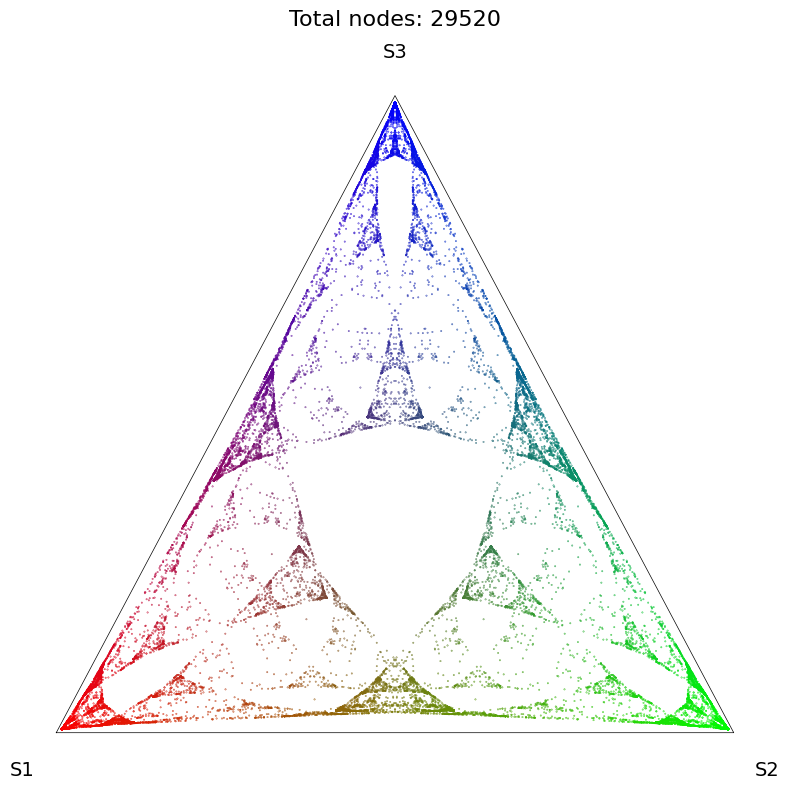

In [6]:
# -----------------------------
# 7) Create the MSP dataset and visualize belief states.
# -----------------------------
# Vocab: tokens 0,1,2 and PAD token 3 -> vocab_size = 4.
num_tokens = 4
dataset = MSPDataset(T_dict, stationary, depth=9)
plot_msp_dataset(dataset)

# -----------------------------
# 8) Set up a DataLoader for the Sparse Autoencoder.
#    Here we train the autoencoder on belief states only.
# -----------------------------
# Create a simple Dataset that returns only the belief state
class BeliefDataset(Dataset):
    def __init__(self, msp_dataset):
        self.beliefs = msp_dataset.beliefs

    def __len__(self):
        return len(self.beliefs)

    def __getitem__(self, idx):
        return torch.tensor(self.beliefs[idx], dtype=torch.float)

belief_dataset = BeliefDataset(dataset)
belief_dataloader = DataLoader(belief_dataset, batch_size=64, shuffle=True)


In [7]:
# -----------------------------
# 9) Define a Sparse Autoencoder (SAE)
# -----------------------------
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=16):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Since belief states are in [0,1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

  1%|          | 100/10000 [01:30<2:28:05,  1.11it/s]

Epoch 100, Loss: 0.000299


  2%|▏         | 200/10000 [03:01<2:26:30,  1.11it/s]

Epoch 200, Loss: 0.000164


  3%|▎         | 300/10000 [04:31<2:23:42,  1.12it/s]

Epoch 300, Loss: 0.000139


  4%|▍         | 400/10000 [06:02<2:24:21,  1.11it/s]

Epoch 400, Loss: 0.000132


  5%|▌         | 500/10000 [07:34<2:21:38,  1.12it/s]

Epoch 500, Loss: 0.000116


  6%|▌         | 600/10000 [09:03<2:19:30,  1.12it/s]

Epoch 600, Loss: 0.000077


  7%|▋         | 700/10000 [10:34<2:19:10,  1.11it/s]

Epoch 700, Loss: 0.000073


  8%|▊         | 800/10000 [12:05<2:17:46,  1.11it/s]

Epoch 800, Loss: 0.000071


  9%|▉         | 900/10000 [13:34<2:16:32,  1.11it/s]

Epoch 900, Loss: 0.000070


 10%|█         | 1000/10000 [15:05<2:14:42,  1.11it/s]

Epoch 1000, Loss: 0.000069


 11%|█         | 1100/10000 [16:35<2:12:03,  1.12it/s]

Epoch 1100, Loss: 0.000069


 12%|█▏        | 1200/10000 [18:05<2:10:58,  1.12it/s]

Epoch 1200, Loss: 0.000067


 13%|█▎        | 1300/10000 [19:35<2:09:32,  1.12it/s]

Epoch 1300, Loss: 0.000067


 14%|█▍        | 1400/10000 [21:05<2:09:52,  1.10it/s]

Epoch 1400, Loss: 0.000066


 15%|█▌        | 1500/10000 [22:36<2:08:22,  1.10it/s]

Epoch 1500, Loss: 0.000066


 16%|█▌        | 1600/10000 [24:06<2:08:04,  1.09it/s]

Epoch 1600, Loss: 0.000065


 17%|█▋        | 1700/10000 [25:37<2:05:22,  1.10it/s]

Epoch 1700, Loss: 0.000065


 18%|█▊        | 1800/10000 [27:08<2:04:33,  1.10it/s]

Epoch 1800, Loss: 0.000065


 19%|█▉        | 1900/10000 [28:38<2:01:55,  1.11it/s]

Epoch 1900, Loss: 0.000065


 20%|██        | 2000/10000 [30:08<2:00:37,  1.11it/s]

Epoch 2000, Loss: 0.000064


 21%|██        | 2100/10000 [31:39<1:58:53,  1.11it/s]

Epoch 2100, Loss: 0.000065


 22%|██▏       | 2200/10000 [33:09<1:57:06,  1.11it/s]

Epoch 2200, Loss: 0.000064


 23%|██▎       | 2300/10000 [34:40<1:58:00,  1.09it/s]

Epoch 2300, Loss: 0.000063


 24%|██▍       | 2400/10000 [36:10<1:53:26,  1.12it/s]

Epoch 2400, Loss: 0.000064


 25%|██▌       | 2500/10000 [37:40<1:53:12,  1.10it/s]

Epoch 2500, Loss: 0.000064


 26%|██▌       | 2600/10000 [39:10<1:49:15,  1.13it/s]

Epoch 2600, Loss: 0.000063


 27%|██▋       | 2700/10000 [40:40<1:48:51,  1.12it/s]

Epoch 2700, Loss: 0.000063


 28%|██▊       | 2800/10000 [42:11<1:48:10,  1.11it/s]

Epoch 2800, Loss: 0.000063


 29%|██▉       | 2900/10000 [43:41<1:46:59,  1.11it/s]

Epoch 2900, Loss: 0.000063


 30%|███       | 3000/10000 [45:13<1:46:16,  1.10it/s]

Epoch 3000, Loss: 0.000063


 31%|███       | 3100/10000 [46:43<1:43:42,  1.11it/s]

Epoch 3100, Loss: 0.000064


 32%|███▏      | 3200/10000 [48:13<1:43:42,  1.09it/s]

Epoch 3200, Loss: 0.000063


 33%|███▎      | 3300/10000 [49:44<1:40:23,  1.11it/s]

Epoch 3300, Loss: 0.000063


 34%|███▍      | 3400/10000 [51:14<1:38:53,  1.11it/s]

Epoch 3400, Loss: 0.000063


 35%|███▌      | 3500/10000 [52:44<1:37:25,  1.11it/s]

Epoch 3500, Loss: 0.000062


 36%|███▌      | 3600/10000 [54:16<1:35:06,  1.12it/s]

Epoch 3600, Loss: 0.000062


 37%|███▋      | 3700/10000 [55:46<1:33:53,  1.12it/s]

Epoch 3700, Loss: 0.000062


 38%|███▊      | 3800/10000 [57:15<1:31:54,  1.12it/s]

Epoch 3800, Loss: 0.000062


 39%|███▉      | 3900/10000 [58:47<1:31:05,  1.12it/s]

Epoch 3900, Loss: 0.000063


 40%|████      | 4000/10000 [1:00:18<1:29:14,  1.12it/s]

Epoch 4000, Loss: 0.000062


 41%|████      | 4100/10000 [1:01:50<1:28:11,  1.12it/s]

Epoch 4100, Loss: 0.000056


 42%|████▏     | 4200/10000 [1:03:20<1:26:50,  1.11it/s]

Epoch 4200, Loss: 0.000054


 43%|████▎     | 4300/10000 [1:04:53<1:27:31,  1.09it/s]

Epoch 4300, Loss: 0.000054


 44%|████▍     | 4400/10000 [1:06:24<1:26:28,  1.08it/s]

Epoch 4400, Loss: 0.000053


 45%|████▌     | 4500/10000 [1:07:55<1:22:17,  1.11it/s]

Epoch 4500, Loss: 0.000053


 46%|████▌     | 4600/10000 [1:09:26<1:20:56,  1.11it/s]

Epoch 4600, Loss: 0.000053


 47%|████▋     | 4700/10000 [1:10:57<1:22:00,  1.08it/s]

Epoch 4700, Loss: 0.000052


 48%|████▊     | 4800/10000 [1:12:28<1:16:53,  1.13it/s]

Epoch 4800, Loss: 0.000053


 49%|████▉     | 4900/10000 [1:13:59<1:17:29,  1.10it/s]

Epoch 4900, Loss: 0.000052


 50%|█████     | 5000/10000 [1:15:30<1:14:42,  1.12it/s]

Epoch 5000, Loss: 0.000052


 51%|█████     | 5100/10000 [1:17:01<1:12:46,  1.12it/s]

Epoch 5100, Loss: 0.000053


 52%|█████▏    | 5200/10000 [1:18:32<1:11:57,  1.11it/s]

Epoch 5200, Loss: 0.000053


 53%|█████▎    | 5300/10000 [1:20:02<1:13:03,  1.07it/s]

Epoch 5300, Loss: 0.000052


 54%|█████▍    | 5400/10000 [1:21:34<1:09:38,  1.10it/s]

Epoch 5400, Loss: 0.000051


 55%|█████▌    | 5500/10000 [1:23:06<1:09:23,  1.08it/s]

Epoch 5500, Loss: 0.000052


 56%|█████▌    | 5600/10000 [1:24:37<1:06:48,  1.10it/s]

Epoch 5600, Loss: 0.000052


 57%|█████▋    | 5700/10000 [1:26:09<1:04:32,  1.11it/s]

Epoch 5700, Loss: 0.000052


 58%|█████▊    | 5800/10000 [1:27:40<1:02:44,  1.12it/s]

Epoch 5800, Loss: 0.000052


 59%|█████▉    | 5900/10000 [1:29:10<1:02:07,  1.10it/s]

Epoch 5900, Loss: 0.000052


 60%|██████    | 6000/10000 [1:30:40<1:00:19,  1.11it/s]

Epoch 6000, Loss: 0.000053


 61%|██████    | 6100/10000 [1:32:11<59:34,  1.09it/s]

Epoch 6100, Loss: 0.000053


 62%|██████▏   | 6200/10000 [1:33:41<57:55,  1.09it/s]

Epoch 6200, Loss: 0.000052


 63%|██████▎   | 6300/10000 [1:35:12<56:28,  1.09it/s]

Epoch 6300, Loss: 0.000053


 64%|██████▍   | 6400/10000 [1:36:43<55:22,  1.08it/s]

Epoch 6400, Loss: 0.000052


 65%|██████▌   | 6500/10000 [1:38:13<52:58,  1.10it/s]

Epoch 6500, Loss: 0.000052


 66%|██████▌   | 6600/10000 [1:39:44<51:07,  1.11it/s]

Epoch 6600, Loss: 0.000051


 67%|██████▋   | 6700/10000 [1:41:15<50:43,  1.08it/s]

Epoch 6700, Loss: 0.000051


 68%|██████▊   | 6800/10000 [1:42:46<48:08,  1.11it/s]

Epoch 6800, Loss: 0.000052


 69%|██████▉   | 6900/10000 [1:44:17<47:22,  1.09it/s]

Epoch 6900, Loss: 0.000052


 70%|███████   | 7000/10000 [1:45:47<45:03,  1.11it/s]

Epoch 7000, Loss: 0.000052


 71%|███████   | 7100/10000 [1:47:17<44:33,  1.08it/s]

Epoch 7100, Loss: 0.000051


 72%|███████▏  | 7200/10000 [1:48:49<42:07,  1.11it/s]

Epoch 7200, Loss: 0.000051


 73%|███████▎  | 7300/10000 [1:50:19<41:34,  1.08it/s]

Epoch 7300, Loss: 0.000051


 74%|███████▍  | 7400/10000 [1:51:50<39:58,  1.08it/s]

Epoch 7400, Loss: 0.000051


 75%|███████▌  | 7500/10000 [1:53:20<37:41,  1.11it/s]

Epoch 7500, Loss: 0.000051


 76%|███████▌  | 7600/10000 [1:54:52<36:12,  1.10it/s]

Epoch 7600, Loss: 0.000051


 77%|███████▋  | 7700/10000 [1:56:24<35:41,  1.07it/s]

Epoch 7700, Loss: 0.000051


 78%|███████▊  | 7800/10000 [1:57:55<32:55,  1.11it/s]

Epoch 7800, Loss: 0.000051


 79%|███████▉  | 7900/10000 [1:59:25<31:17,  1.12it/s]

Epoch 7900, Loss: 0.000051


 80%|████████  | 8000/10000 [2:00:57<31:12,  1.07it/s]

Epoch 8000, Loss: 0.000051


 81%|████████  | 8100/10000 [2:02:28<29:15,  1.08it/s]

Epoch 8100, Loss: 0.000051


 82%|████████▏ | 8200/10000 [2:03:59<26:57,  1.11it/s]

Epoch 8200, Loss: 0.000051


 83%|████████▎ | 8300/10000 [2:05:29<25:46,  1.10it/s]

Epoch 8300, Loss: 0.000051


 84%|████████▍ | 8400/10000 [2:06:59<23:53,  1.12it/s]

Epoch 8400, Loss: 0.000051


 85%|████████▌ | 8500/10000 [2:08:30<22:59,  1.09it/s]

Epoch 8500, Loss: 0.000051


 86%|████████▌ | 8600/10000 [2:10:00<20:59,  1.11it/s]

Epoch 8600, Loss: 0.000051


 87%|████████▋ | 8700/10000 [2:11:31<19:26,  1.11it/s]

Epoch 8700, Loss: 0.000050


 88%|████████▊ | 8800/10000 [2:13:02<18:16,  1.09it/s]

Epoch 8800, Loss: 0.000051


 89%|████████▉ | 8900/10000 [2:14:32<16:31,  1.11it/s]

Epoch 8900, Loss: 0.000051


 90%|█████████ | 9000/10000 [2:16:02<14:56,  1.12it/s]

Epoch 9000, Loss: 0.000050


 91%|█████████ | 9100/10000 [2:17:32<13:29,  1.11it/s]

Epoch 9100, Loss: 0.000051


 92%|█████████▏| 9200/10000 [2:19:03<12:00,  1.11it/s]

Epoch 9200, Loss: 0.000051


 93%|█████████▎| 9300/10000 [2:20:34<10:56,  1.07it/s]

Epoch 9300, Loss: 0.000050


 94%|█████████▍| 9400/10000 [2:22:05<08:59,  1.11it/s]

Epoch 9400, Loss: 0.000051


 95%|█████████▌| 9500/10000 [2:23:35<07:26,  1.12it/s]

Epoch 9500, Loss: 0.000051


 96%|█████████▌| 9600/10000 [2:25:08<06:14,  1.07it/s]

Epoch 9600, Loss: 0.000051


 97%|█████████▋| 9700/10000 [2:26:40<04:32,  1.10it/s]

Epoch 9700, Loss: 0.000050


 98%|█████████▊| 9800/10000 [2:28:11<02:59,  1.12it/s]

Epoch 9800, Loss: 0.000051


 99%|█████████▉| 9900/10000 [2:29:41<01:29,  1.11it/s]

Epoch 9900, Loss: 0.000051


100%|██████████| 10000/10000 [2:31:13<00:00,  1.10it/s]

Epoch 10000, Loss: 0.000050


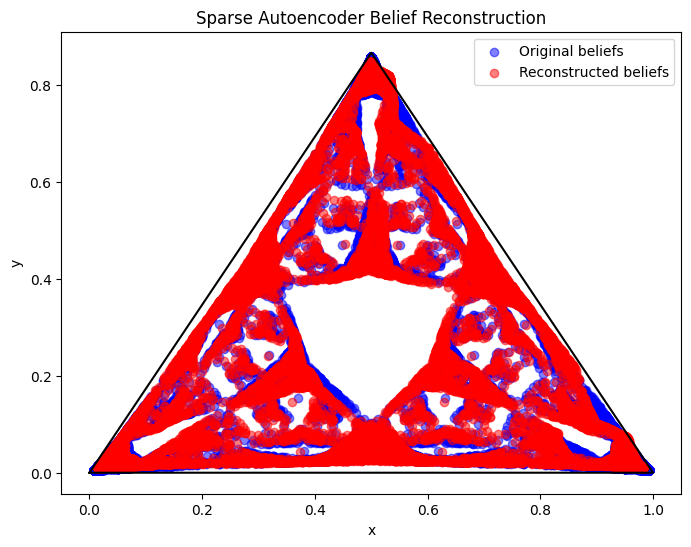

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sparse_autoencoder = SparseAutoencoder(input_dim=3, hidden_dim=16).to(device)
optimizer = optim.Adam(sparse_autoencoder.parameters(), lr=0.001)
reconstruction_criterion = nn.MSELoss()

# Sparsity coefficient (tune this hyperparameter)
sparsity_lambda = 1e-3

# -----------------------------
# 10) Train the Sparse Autoencoder
# -----------------------------
num_epochs =  10000
for epoch in tqdm(range(num_epochs)):
    sparse_autoencoder.train()
    epoch_loss = 0
    for belief_batch in belief_dataloader:
        belief_batch = belief_batch.to(device)
        optimizer.zero_grad()
        reconstruction, latent = sparse_autoencoder(belief_batch)
        # Reconstruction loss
        loss_reconstruction = reconstruction_criterion(reconstruction, belief_batch)
        # Sparsity penalty: L1 norm on latent activations
        loss_sparsity = torch.mean(torch.abs(latent))
        loss = loss_reconstruction + sparsity_lambda * loss_sparsity
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(belief_dataloader):.6f}")

# -----------------------------
# 11) Visualization: Compare original and reconstructed belief states.
# -----------------------------
sparse_autoencoder.eval()
all_beliefs = []
all_reconstructions = []
with torch.no_grad():
    for belief_batch in belief_dataloader:
        belief_batch = belief_batch.to(device)
        reconstruction, _ = sparse_autoencoder(belief_batch)
        all_beliefs.append(belief_batch.cpu().numpy())
        all_reconstructions.append(reconstruction.cpu().numpy())
all_beliefs = np.concatenate(all_beliefs, axis=0)
all_reconstructions = np.concatenate(all_reconstructions, axis=0)

def barycentric_to_cartesian(b):
    A = np.array([0, 0])
    B = np.array([1, 0])
    C = np.array([0.5, np.sqrt(3)/2])
    return b[0]*A + b[1]*B + b[2]*C

cartesian_beliefs = np.array([barycentric_to_cartesian(b) for b in all_beliefs])
cartesian_reconstructions = np.array([barycentric_to_cartesian(b) for b in all_reconstructions])

plt.figure(figsize=(8,6))
plt.scatter(cartesian_beliefs[:,0], cartesian_beliefs[:,1], color='blue', alpha=0.5, label='Original beliefs')
plt.scatter(cartesian_reconstructions[:,0], cartesian_reconstructions[:,1], color='red', alpha=0.5, label='Reconstructed beliefs')
triangle = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2], [0,0]])
plt.plot(triangle[:,0], triangle[:,1], color='black')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sparse Autoencoder Belief Reconstruction")
plt.legend()
plt.show()


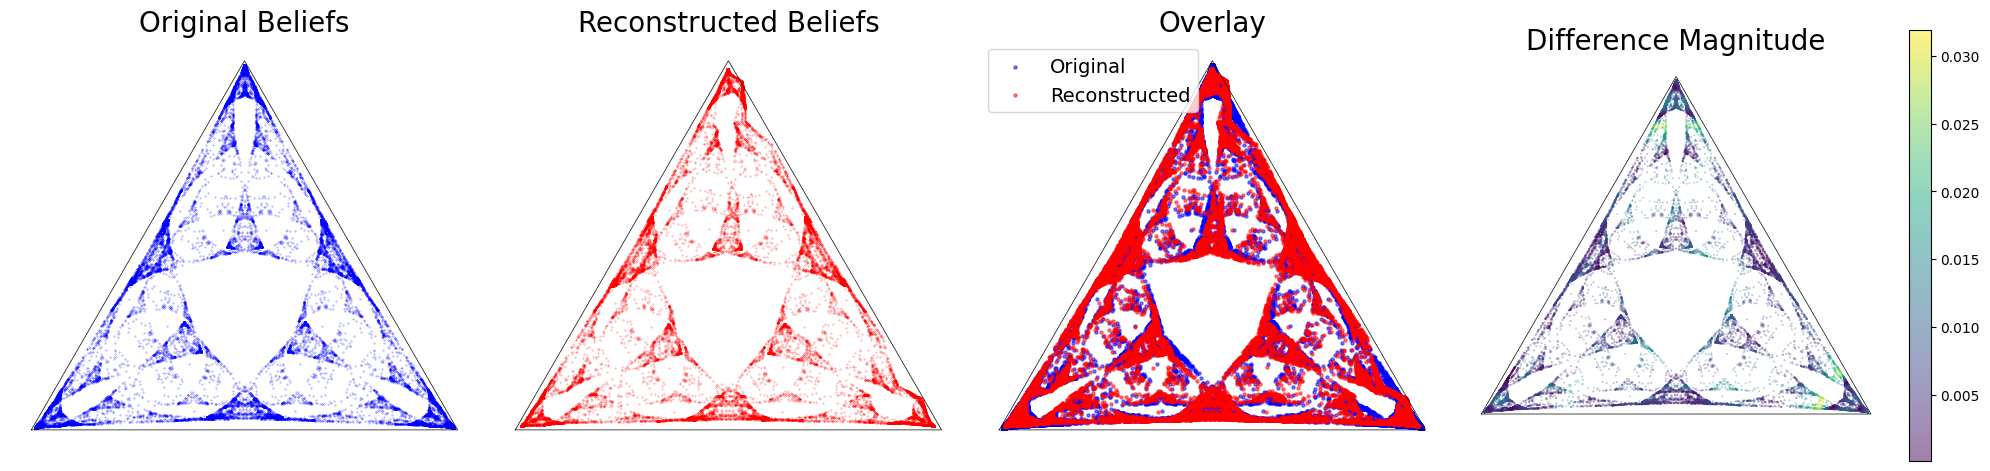

In [10]:
# -----------------------------
# 11) Visualization: Compare original and reconstructed belief states.
#     (Updated to a multi-panel plot similar to your reference.)
# -----------------------------
sparse_autoencoder.eval()
all_beliefs = []
all_reconstructions = []
with torch.no_grad():
    for belief_batch in belief_dataloader:
        belief_batch = belief_batch.to(device)
        reconstruction, _ = sparse_autoencoder(belief_batch)
        all_beliefs.append(belief_batch.cpu().numpy())
        all_reconstructions.append(reconstruction.cpu().numpy())
all_beliefs = np.concatenate(all_beliefs, axis=0)
all_reconstructions = np.concatenate(all_reconstructions, axis=0)

def barycentric_to_cartesian(b):
    A = np.array([0, 0])
    B = np.array([1, 0])
    C = np.array([0.5, np.sqrt(3)/2])
    return b[0]*A + b[1]*B + b[2]*C

# Project each belief from the simplex (barycentric) to 2D Cartesian coordinates.
cartesian_beliefs = np.array([barycentric_to_cartesian(b) for b in all_beliefs])
cartesian_reconstructions = np.array([barycentric_to_cartesian(b) for b in all_reconstructions])

# Define the triangle (simplex) boundary.
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])

# Create a 1x4 subplot figure.
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# --- Panel 1: Original Beliefs ---
axes[0].scatter(cartesian_beliefs[:, 0], cartesian_beliefs[:, 1], s=0.1, color='blue', alpha=0.5)
axes[0].plot(triangle[:, 0], triangle[:, 1], color='black', linewidth=0.5)
axes[0].set_title("Original Beliefs", fontsize=20)

# --- Panel 2: Reconstructed Beliefs ---
axes[1].scatter(cartesian_reconstructions[:, 0], cartesian_reconstructions[:, 1], s=0.1, color='red', alpha=0.5)
axes[1].plot(triangle[:, 0], triangle[:, 1], color='black', linewidth=0.5)
axes[1].set_title("Reconstructed Beliefs", fontsize=20)

# --- Panel 3: Overlay ---
axes[2].scatter(cartesian_beliefs[:, 0], cartesian_beliefs[:, 1], s=5, color='blue', alpha=0.5, label='Original')
axes[2].scatter(cartesian_reconstructions[:, 0], cartesian_reconstructions[:, 1], s=5, color='red', alpha=0.5, label='Reconstructed')
axes[2].plot(triangle[:, 0], triangle[:, 1], color='black', linewidth=0.5)
axes[2].set_title("Overlay", fontsize=20)
axes[2].legend(fontsize=14)

# --- Panel 4: Difference Magnitude ---
# Compute the Euclidean distance between each original and reconstructed belief.
differences = np.linalg.norm(cartesian_beliefs - cartesian_reconstructions, axis=1)
sc = axes[3].scatter(cartesian_beliefs[:, 0], cartesian_beliefs[:, 1], s=0.1,
                      c=differences, cmap='viridis', alpha=0.5)
axes[3].plot(triangle[:, 0], triangle[:, 1], color='black', linewidth=0.5)
axes[3].set_title("Difference Magnitude", fontsize=20)
plt.colorbar(sc, ax=axes[3], fraction=0.046, pad=0.04)

# Format each subplot: remove axes, frames, set aspect ratio, and define limits.
for ax in axes:
    ax.axis('off')
    ax.set_frame_on(False)
    ax.set_aspect('equal')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, (np.sqrt(3)/2) + 0.05])

plt.tight_layout()
plt.show()
